# DAQL for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('BipedalWalker-v2')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
# state = env.reset()
# batch = []
# for _ in range(1111):
#     #env.render()
#     action = env.action_space.sample()
#     next_state, reward, done, _ = env.step(action) # take a random action
#     batch.append([state, action, next_state, reward, float(done)])
#     state = next_state
#     if done:
#         state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print('states:', np.max(np.array(states)), np.min(np.array(states)))
# print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

In [8]:
# env.action_space.high, env.action_space.low

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [12]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_shape], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_state')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    return states, actions, next_states, rewards, dones

In [13]:
# a = act(s)
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False, trainable=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size, trainable=trainable)
        bn1 = tf.layers.batch_normalization(h1, training=training, trainable=trainable)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size, trainable=trainable)
        bn2 = tf.layers.batch_normalization(h2, training=training, trainable=trainable)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size, trainable=trainable)        
        pred = tf.tanh(logits)
        return pred

In [14]:
# s', Q = env(s, a)
def discriminator(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False, 
                  trainable=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size, trainable=trainable)
        bn1 = tf.layers.batch_normalization(h1, training=training, trainable=trainable)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size, trainable=trainable)
        bn2 = tf.layers.batch_normalization(h2, training=training, trainable=trainable)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        next_states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=trainable)        
        Qlogits = tf.layers.dense(inputs=next_states_logits, units=1, trainable=False)        
        return next_states_logits, Qlogits

In [15]:
def model_loss(action_size, hidden_size, state_size, 
               states, actions, next_states, rewards, dones):
    actions_pred = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gen_next_states, gQs = discriminator(actions=actions_pred, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size) 
    gloss = -tf.reduce_mean(gQs)
    gloss += -tf.reduce_mean(tf.reduce_sum(tf.square(gen_next_states - next_states), axis=1))
    next_actions_pred = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                  trainable=False, reuse=True)
    _, nextQs = discriminator(actions=next_actions_pred, states=next_states, hidden_size=hidden_size,
                              action_size=action_size, state_size=state_size, 
                              trainable=False, reuse=True) 
    targetQs = nextQs * (1-dones)
    next_states_pred, Qs = discriminator(actions=actions, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    rewards_in = Qs - targetQs
    dloss = tf.reduce_mean(tf.square(rewards_in - rewards))
    dloss += tf.reduce_mean(tf.reduce_sum(tf.square(next_states_pred - next_states), axis=1))
    return actions_pred, gloss, dloss

In [16]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):
        
        # Model inputs
        self.states, self.actions, self.next_states, self.rewards, self.dones = model_input(
            state_size=state_size, action_size=action_size)

        # Model loss/objective
        self.actions_pred, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones)
        
        # Model optimization/update
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [20]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size == one episode size is 1000/int(1e3) steps
gamma = 0.99                   # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [22]:
env.observation_space.high, env.observation_space.low, env.observation_space, \
env.action_space.high, env.action_space.low, env.action_space, \
env.reward_range

(array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32),
 array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 Box(24,),
 array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32),
 Box(4,),
 (-inf, inf))

In [23]:
state = env.reset()
for each_step in range(memory_size):
    action = env.action_space.sample() # randomness
    action = np.clip(action, -1, 1) # clipped: [-1, +1]
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        print('Progress:', each_step/memory_size)
        state = env.reset()

Progress: 0.01599
Progress: 0.01673
Progress: 0.01759
Progress: 0.0183
Progress: 0.01924
Progress: 0.01992
Progress: 0.02086
Progress: 0.02214
Progress: 0.03814
Progress: 0.03891
Progress: 0.05491
Progress: 0.07091
Progress: 0.07167
Progress: 0.08767
Progress: 0.0884
Progress: 0.08877
Progress: 0.09903
Progress: 0.11503
Progress: 0.13103
Progress: 0.13157
Progress: 0.14757
Progress: 0.16357
Progress: 0.1644
Progress: 0.1804
Progress: 0.1964
Progress: 0.2124
Progress: 0.2284
Progress: 0.22894
Progress: 0.24494
Progress: 0.2462
Progress: 0.24715
Progress: 0.26315
Progress: 0.26379
Progress: 0.26526
Progress: 0.26595
Progress: 0.28195
Progress: 0.28269
Progress: 0.28396
Progress: 0.28468
Progress: 0.30068
Progress: 0.31668
Progress: 0.31759
Progress: 0.33359
Progress: 0.34959
Progress: 0.36559
Progress: 0.36643
Progress: 0.36689
Progress: 0.36788
Progress: 0.38388
Progress: 0.38465
Progress: 0.3852
Progress: 0.38605
Progress: 0.40205
Progress: 0.40265
Progress: 0.41865
Progress: 0.43465
P

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
len(memory.buffer), memory.buffer.maxlen

(100000, 100000)

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            env.render()
            
            action_pred = sess.run(model.actions_pred, feed_dict={model.states: state.reshape([1, -1])})
            noise = np.random.normal(loc=0, scale=0.1, size=action_size) # randomness
            action = action_pred.reshape([-1]) + noise
            #print(action.shape, action_logits.shape, noise.shape)
            action = np.clip(action, -1, 1) # clipped
            
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state
            
            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #print(states.shape, states_.shape, actions.shape, next_states.shape)
            #print(states.dtype, states_.dtype, actions.dtype, next_states.dtype)
            #next_states_logits = sess.run(model.next_states_pred, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
            #nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
            #targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states, 
                                                       model.rewards: rewards, 
                                                       model.dones: dones})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:-134.1628 R:-134.1628 gloss:-8.4395 dloss:17.1439
Episode:1 meanR:-116.9916 R:-99.8203 gloss:-7.4865 dloss:17.7359
Episode:2 meanR:-111.4069 R:-100.2377 gloss:-6.8617 dloss:19.9245
Episode:3 meanR:-108.6739 R:-100.4746 gloss:-6.1922 dloss:16.4785
Episode:4 meanR:-107.0523 R:-100.5663 gloss:-5.6342 dloss:14.4970
Episode:5 meanR:-106.0057 R:-100.7725 gloss:-5.1882 dloss:18.6262
Episode:6 meanR:-105.2809 R:-100.9323 gloss:-4.7711 dloss:15.0669
Episode:7 meanR:-104.7597 R:-101.1112 gloss:-4.5317 dloss:11.9676
Episode:8 meanR:-104.7341 R:-104.5288 gloss:-4.2148 dloss:16.8303
Episode:9 meanR:-104.3802 R:-101.1957 gloss:-4.0651 dloss:12.7108
Episode:10 meanR:-104.0966 R:-101.2606 gloss:-3.9927 dloss:12.5853
Episode:11 meanR:-103.8576 R:-101.2280 gloss:-3.9305 dloss:8.2002
Episode:12 meanR:-103.6606 R:-101.2973 gloss:-3.9352 dloss:13.8947
Episode:13 meanR:-103.4800 R:-101.1314 gloss:-3.9014 dloss:6.6799
Episode:14 meanR:-103.3297 R:-101.2261 gloss:-3.9255 dloss:10.9043
Episode:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

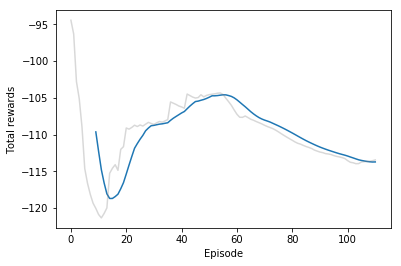

In [44]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

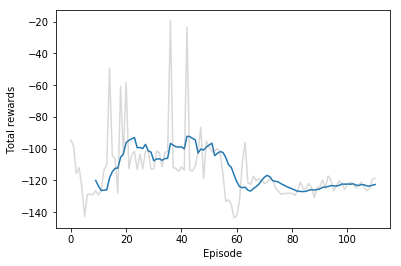

In [45]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

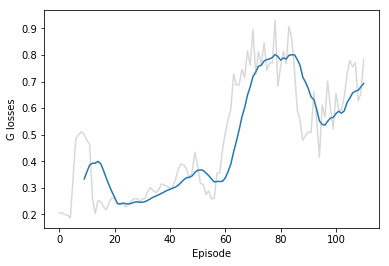

In [46]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

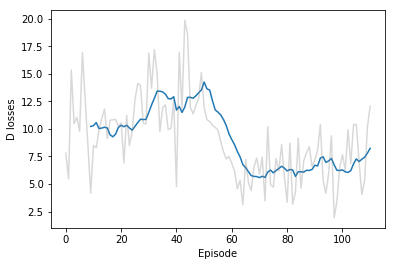

In [47]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [46]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_logits, [-1]) # For continuous action space
            #action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -130.50857430583363


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.